In [1]:
%matplotlib inline
from config_calc import *

import matplotlib
import matplotlib.pyplot as plt
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'

import cmocean
import plot_tools

#dataroot = '/glade/p/ncgd0033/obs'
#dataroot = '/project/oce/mclong'
dataroot = '~/data'

### read woa data

In [2]:
woapth = os.path.join(dataroot,'woa2013v2/1x1d')

woa_info = {
    'O2': {'varname': 'o_an', 'file' : os.path.join(woapth,'woa13_all_o00_01.nc')},   
    'PO4': {'varname': 'p_an', 'file' : os.path.join(woapth,'woa13_all_p00_01.nc')},   
    'NO3': {'varname': 'n_an', 'file' : os.path.join(woapth,'woa13_all_n00_01.nc')}}

woa = {}
for v,info in woa_info.items():   
    varname = info['varname']
    file_in = info['file']
    woai = xr.open_dataset(file_in,decode_times=False)
    woai = woai.drop([k for k in woai if k not in [varname,'lat','lon','depth','depth_bnds']])
    woai = woai.rename({varname:v})
    woai = woai.sel(depth=slice(200,600))
    if woa:
        woa = xr.merge((woa,woai))
    else:
        woa = woai
         
ni = len(woa.lon)
nj = len(woa.lat)

mlperl_2_mmolm3 = 1.e6 / 1.e3 / 22.3916
for v in ['O2']:
    woa[v] = woa[v] * mlperl_2_mmolm3
    woa[v].attrs['units'] = 'mmol m$^{-3}$'


woa['nstar'] = woa.NO3 - woa.PO4 * 16.  
    
woa['dz'] = woa.depth_bnds[:,1] - woa.depth_bnds[:,0]         
woa

<xarray.Dataset>
Dimensions:     (depth: 15, lat: 180, lon: 360, nbounds: 2, time: 1)
Coordinates:
  * lat         (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * lon         (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
  * depth       (depth) float32 200.0 225.0 250.0 275.0 300.0 325.0 350.0 ...
Dimensions without coordinates: nbounds, time
Data variables:
    depth_bnds  (depth, nbounds) float32 187.5 212.5 212.5 237.5 237.5 262.5 ...
    PO4         (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    O2          (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    NO3         (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    nstar       (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    dz          (depth) float32 25.0 25.0 25.0 25.0 25.0 25.0 25.0 25.0 25.0 ...

In [3]:
%%time
nz = woa.depth.shape[0]
nlat = woa.lat.shape[0]
nlon = woa.lon.shape[0]
zmask = xr.DataArray(np.ones(nz),dims='depth')

rmask = xr.DataArray(np.zeros((nz,nlat,nlon)),dims=('depth','lat','lon'))
rmask[:,:,:] = np.where(np.isnan(woa.O2), 0., 1.)
rmask

CPU times: user 5.89 ms, sys: 3.73 ms, total: 9.62 ms
Wall time: 8.08 ms


<xarray.Dataset>
Dimensions:     (depth: 15, lat: 180, lon: 360, nbounds: 2, time: 1)
Coordinates:
  * lat         (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * lon         (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
  * depth       (depth) float32 200.0 225.0 250.0 275.0 300.0 325.0 350.0 ...
Dimensions without coordinates: nbounds, time
Data variables:
    depth_bnds  (depth, nbounds) float32 187.5 212.5 212.5 237.5 237.5 262.5 ...
    PO4         (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    O2          (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    NO3         (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    nstar       (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    dz          (depth) float32 25.0 25.0 25.0 25.0 25.0 25.0 25.0 25.0 25.0 ...


/Users/mclong/Dropbox/miniconda2/lib/python2.7/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in divide
  if not reflexive


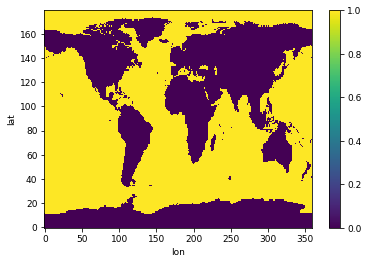

In [4]:
zwgt = (woa.dz*rmask) / (woa.dz*rmask).sum(dim='depth')
print woa
zwgt.sum(dim='depth').plot()

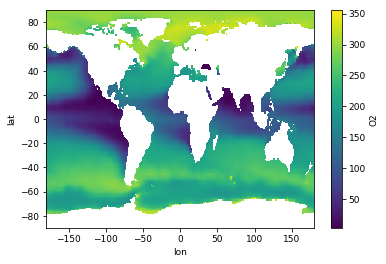

In [5]:
woa_tc = (woa*zwgt).sum(dim='depth').isel(time=0)
woa_tc = woa_tc.where(zwgt.sum(dim='depth')>0)
woa_tc.O2.plot()

### make the plot

initial plot size (display units): 6.98,3.54
Adjusting fig size:
	(W,H in): 10.00,3.00 --> 8.03,6.73
new plot size: 5.61,6.75


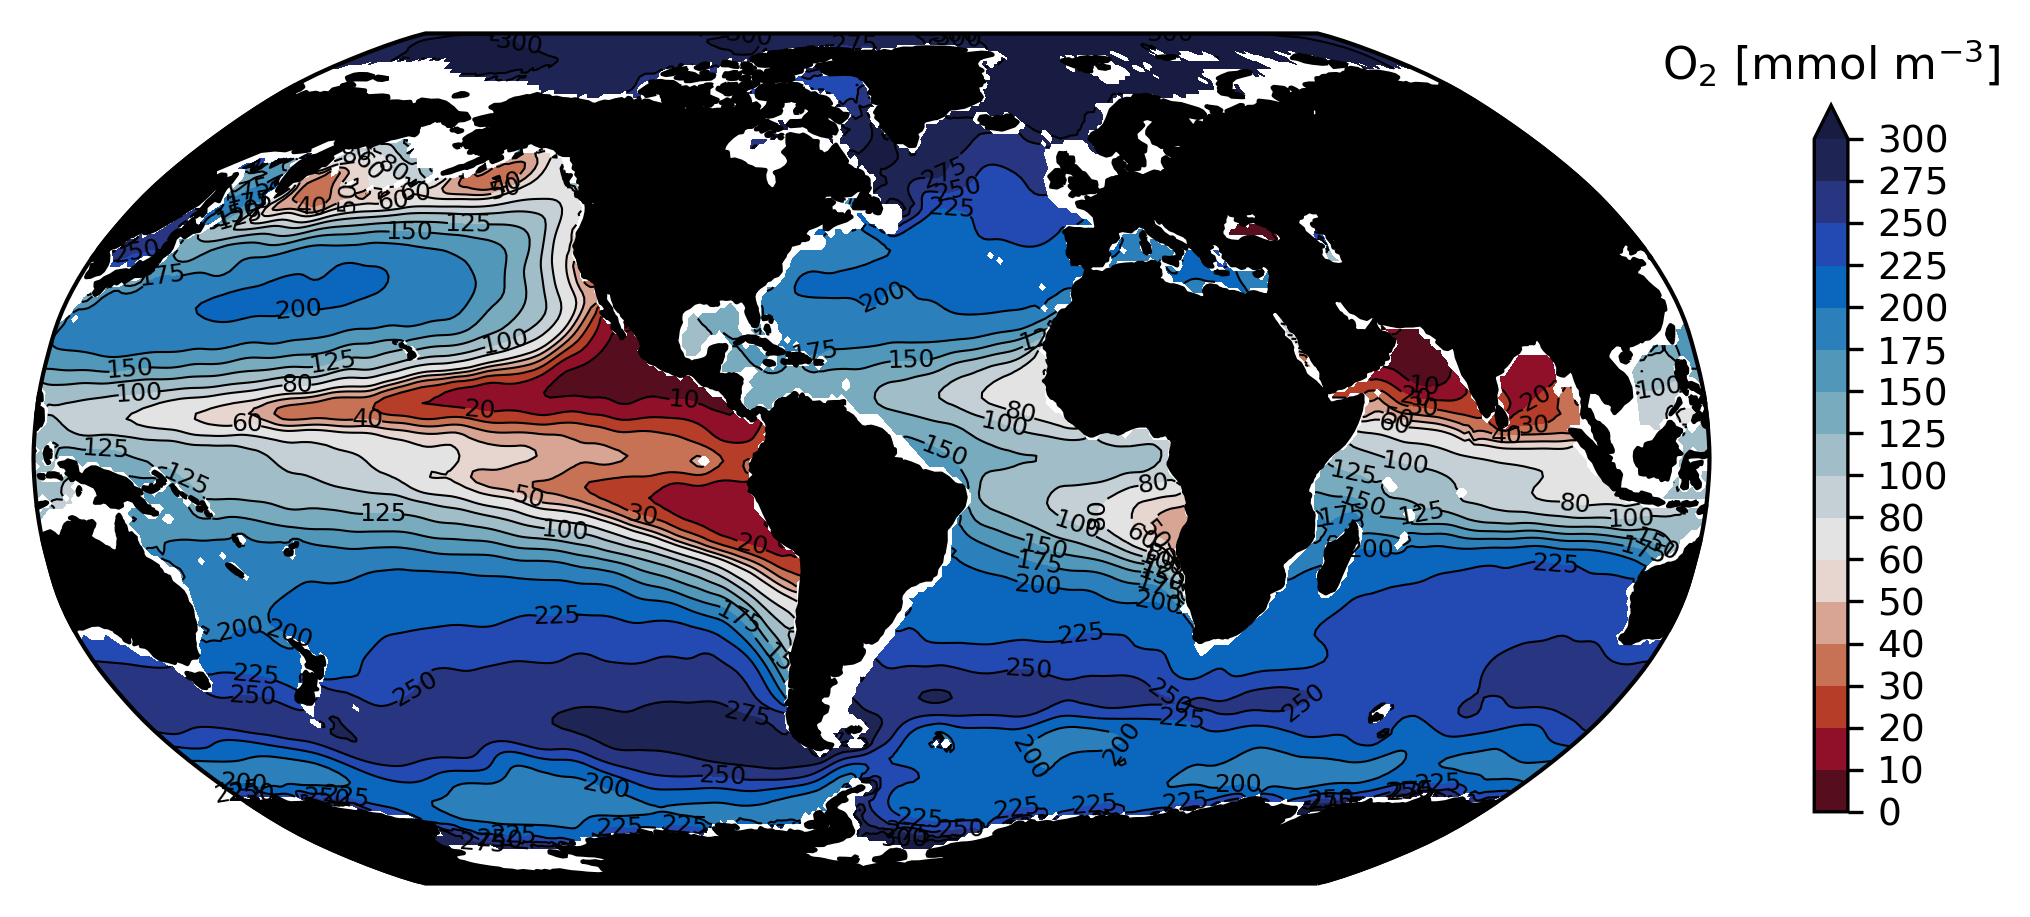

In [6]:
plot_name = os.path.join(diro['talk_fig'],'woa-thermocline-o2.pdf')

norm_o2 = plot_tools.MidPointNorm(midpoint=60.) 
plots = {'O2' : 
         {'ds':woa_tc,
          'units' : 'O$_2$ [mmol m$^{-3}$]',
           'contour_specs': {'levels':[0,10,20,30,40,50,60,80,100,125,150,175,200,225,250,275,300],
                            'cmap':cmocean.cm.balance_r,
                            'norm':norm_o2,'extend':'max'}}}         

matplotlib.rcParams['contour.negative_linestyle'] = 'dashed'

fig=plt.figure(figsize=(10, 3),dpi=300,facecolor=None)
gs = gridspec.GridSpec(1,1)
       
obj = {}
ax = []
for i,(v,specs) in enumerate(plots.items()):
    ds_tc = specs['ds']
    units = specs['units']         
    contour_specs = specs['contour_specs']
          
    lat = ds_tc.lat.values
    lon = ds_tc.lon.values
    z = ds_tc[v].values

    lon = np.where(lon<0.,lon+360.,lon)
    I = np.argsort(lon)
    lon = lon[I]
    z = z[:,I]
    z,lon = add_cyclic_point(z,coord=lon)   
    lon[0] = lon[0]-1e-8
    
    obj[v] = plot_tools.canvas_map_contour_overlay(lon,lat,z,
                                                   contour_specs,
                                                   units = units,
                                                   fig=fig,
                                                   gridspec=gs,
                                                   row=i,col=0)
    ax.append(obj[v]['ax'])

gridspec_kwargs = {'hspace' : -0.1,
                   'wspace' : 0.05,
                   'left' : 0.,
                   'right' : 0.87,
                   'bottom' : 0.,
                   'top' : 1.}
fgsz = plot_tools.plotgrid(fig, gs, ax, [2,1],gridspec_kwargs)

plt.savefig(plot_name,dpi=300,bbox_inches='tight')
          

/Users/mclong/Dropbox/miniconda2/lib/python2.7/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


initial plot size (display units): 6.98,3.54
Adjusting fig size:
	(W,H in): 10.00,3.00 --> 8.03,6.73
new plot size: 5.61,6.75


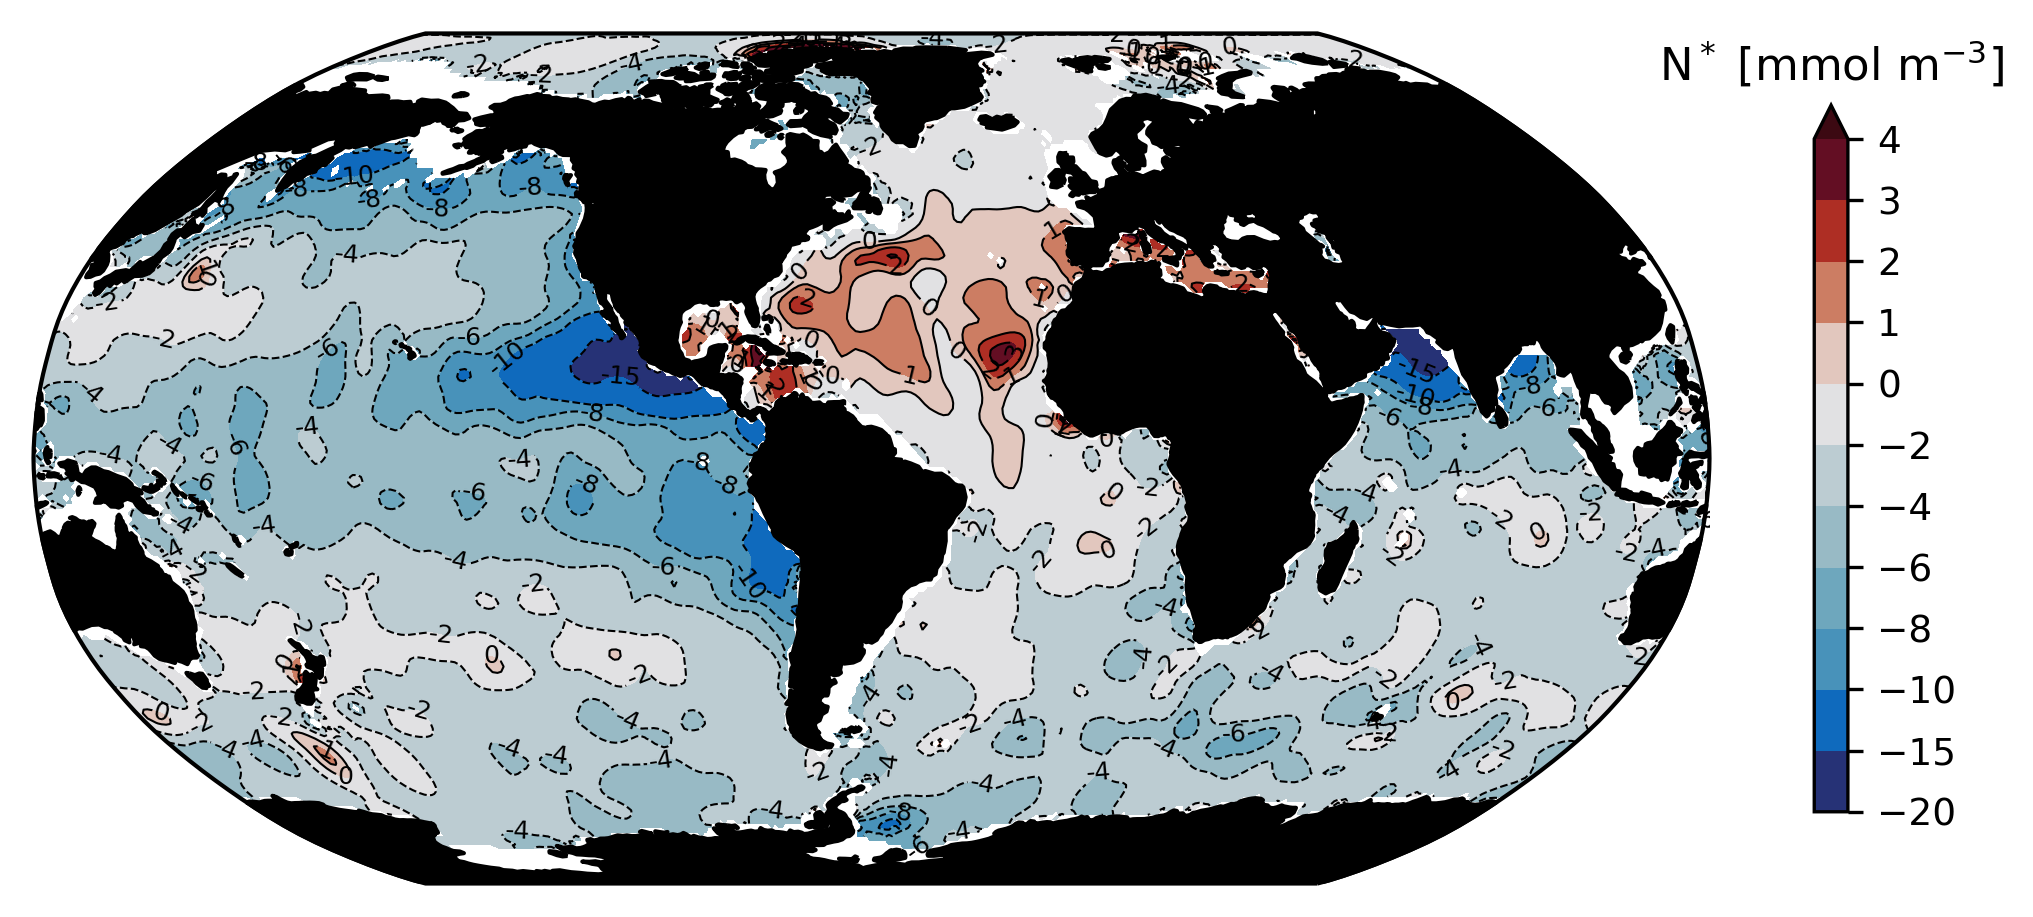

In [7]:

plot_name = os.path.join(diro['talk_fig'],'woa-thermocline-Nstar.pdf')

norm = plot_tools.MidPointNorm(midpoint=0.) 
plots = {'nstar' : 
         {'ds':woa_tc,
          'units' : 'N$^*$ [mmol m$^{-3}$]',
           'contour_specs': {'levels':[-20,-15.,-10.,-8,-6,-4,-2,0.,1,2,3,4],
                            'cmap':cmocean.cm.balance,
                            'norm':norm,'extend':'max'}}}         

matplotlib.rcParams['contour.negative_linestyle'] = 'dashed'

fig=plt.figure(figsize=(10, 3),dpi=300,facecolor=None)
gs = gridspec.GridSpec(1,1)
       
obj = {}
ax = []
for i,(v,specs) in enumerate(plots.items()):
    ds_tc = specs['ds']
    units = specs['units']         
    contour_specs = specs['contour_specs']
          
    lat = ds_tc.lat.values
    lon = ds_tc.lon.values
    z = ds_tc[v].values

    lon = np.where(lon<0.,lon+360.,lon)
    I = np.argsort(lon)
    lon = lon[I]
    z = z[:,I]
    z,lon = add_cyclic_point(z,coord=lon)   
    lon[0] = lon[0]-1e-8
    
    obj[v] = plot_tools.canvas_map_contour_overlay(lon,lat,z,
                                                   contour_specs,
                                                   units = units,
                                                   fig=fig,
                                                   gridspec=gs,
                                                   row=i,col=0)
    ax.append(obj[v]['ax'])

gridspec_kwargs = {'hspace' : -0.1,
                   'wspace' : 0.05,
                   'left' : 0.,
                   'right' : 0.87,
                   'bottom' : 0.,
                   'top' : 1.}
fgsz = plot_tools.plotgrid(fig, gs, ax, [2,1],gridspec_kwargs)

plt.savefig(plot_name,dpi=300,bbox_inches='tight')
          